In [122]:
import mysql.connector
import warnings
import requests
import json
import codecs
from bs4 import BeautifulSoup
import time
import urllib.request, urllib.error, urllib.parse
from pprint import pprint
from types import SimpleNamespace
import re
import os.path
import os
import pandas as pd
from pandas.io import sql
from sqlalchemy import create_engine
import pymysql
import seaborn as sns

In [11]:
#3b saves all non-sponsored item URLs to file
# Not seeing any sponsored item

filename = "deals.txt"

# Define function to save the URL to file
def saveLink(link):
    try:
        file = open(filename, "a")
        file.write(str(link) + "\n")
        file.close()
    except Exception as ex:
        print('Error: ' + str(ex))

# Define function to parse and save the URL
def getURL(html):
    header = {'User-Agent' : 'Mozilla/5.0'}
    page = requests.get(html, headers = header)
    soup = BeautifulSoup(page.content, 'html.parser')
    divs = soup.find_all('div', class_ = 's-item__info clearfix')
    for div in divs:
        link = div.find("a", recursive = False).get('href')
        saveLink(link)
    print('Number of links returned:', len(divs))

# Loop through 8 pages (only showing 8 pages on my end)
for a in range(1, 9):
    print('Scraping page', a)
    html = "https://www.ebay.com/e/daily-deals/hiw-presidents-day-deals-white-sale?rt=nc&_pgn=" + str(a)
    getURL(html)
    time.sleep(10)

Scraping page 1
Number of links returned: 24
Scraping page 2
Number of links returned: 24
Scraping page 3
Number of links returned: 24
Scraping page 4
Number of links returned: 24
Scraping page 5
Number of links returned: 24
Scraping page 6
Number of links returned: 24
Scraping page 7
Number of links returned: 24
Scraping page 8
Number of links returned: 16


In [12]:
#3c save each link to html
txt = open("deals.txt", "r", encoding='utf-8').read().split("\n")
for line in txt:
    h_name = str(line.split('/')[-1].split('?')[0]) + ".html"
    header = {'User-Agent' : 'Mozilla/5.0'}
    request = urllib.request.Request(line, headers = header)
    response = urllib.request.urlopen(request)
    webContent = response.read()
    savepath = r'D:\deals'
    completepath = os.path.join(savepath, h_name) 
    htm = open(completepath, 'wb')
    htm.write(webContent)
    htm.close
    time.sleep(4)

ValueError: unknown url type: ''

In [55]:
# 3d 

# Function to get seller name
def getSellername(soup):
    try:
        sellername = soup.find('span', class_ = 'mbg-nw').text      ## selector command
        return sellername
    except:
        sellername = None

# Function to get seller score
def getSellerscore(soup):
    try:
        sellerscore = soup.find('span', class_ = 'mbg-l').find('a').text      ## selector command       
        return sellerscore
    except:
        sellerscore = None

# Function to get item price
def getItemprice(soup):
    try:
        itemprice = soup.find('span', id = 'prcIsum').text      ## selector command
        itemprice = re.sub(r'[^\d.]', '', itemprice)
        itemprice = int(float(itemprice) * 100)
        return itemprice
    except:
        itemprice = None

# Function to get list price
def getListprice(soup):
    try:
        listprice = soup.find('span', class_ = 'notranslate ms-orp').text      ## selector command
        listprice = re.sub(r'[^\d.]', '', listprice)
        listprice = int(float(listprice) * 100)    
        return listprice
    except:
        listprice = None

# Funtion to get items sold
def getItemsold(soup):
    try:
        itemsold = soup.find('a', class_ = 'vi-txt-underline').text      ## selector command
        itemsold = re.sub(r'[^\d.]', '', itemsold)
        return itemsold
    except:
        itemsold = None

# Function to get title
def getTitle(soup):
    try:
        title = soup.find('h1', id = 'itemTitle').text      ## selector command
        title = re.sub(r'Details about  \xa0', r'', title)
        return title
    except:
        title = None
    
# Function to get returns allowed
def getReturn(soup):
    try:
        returns = soup.find('span', id = 'vi-ret-accrd-txt').text      ## selector command
        if returns == 'No returns':
            return_allowed = False
        else:
            return_allowed = True
        return return_allowed
    except:
        return_allowed = None

# Function to get shipping price
def getShipping(soup):
    try:
        shipping = soup.find('span', id = 'shSummary').text      ## selector command
        if 'FREE' in shipping:
            shipping = 0
        else:
            shipping = re.sub(r'[^\d.]', '', shipping)
            shipping = int(float(shipping) * 100)  
        return shipping
    except:
        shipping = None

# Function to get condition
def getCondition(soup):
    try:
        condition = soup.find('div', id = 'vi-itm-cond').text      ## selector command 
        return condition
    except:
        condition = None

In [135]:
# Iterate through all downloaded pages
path = r'D:\deals'
pages = os.listdir(path)
deals_df = pd.DataFrame(columns = ['seller_name', 'seller_score', 'item_price', 'list_price', 'has_list_price', 'items_sold', 
                                   'title', 'returns_allowed', 'shipping_price', 'condition'])
i = 0

for pa in pages:
    p = os.path.join(path, pa)
    readp = open(p, 'rb').read()
    soupp = BeautifulSoup(readp, 'html.parser')
    seller_name = getSellername(soupp)
    seller_score = getSellerscore(soupp)
    item_price = getItemprice(soupp)
    list_price = getListprice(soupp)
    if getListprice(soupp) == None:
        has_list_price = False
    else:
        has_list_price = True
    items_sold = getItemsold(soupp)
    title = getTitle(soupp)
    returns_allowed = getReturn(soupp)
    shipping_price = getShipping(soupp)
    condition = getCondition(soupp)    
    deals_df.loc[i] = [seller_name, seller_score, item_price, list_price, has_list_price, items_sold, title, returns_allowed, 
                           shipping_price, condition]
    i = i + 1
    time.sleep(4)    

In [136]:
deals_df.rename(columns = {'condition': 'condition_'}, inplace=True)
deals_df

,seller_name,seller_score,item_price,list_price,has_list_price,items_sold,title,returns_allowed,shipping_price,condition_
0,cozyarray,219953,799,1698,True,2795,SET OF 1500 TC PILLOWCASES TWO PILLOW CASES PE...,True,0,New with tags
1,cozyarray,219953,799,1798,True,14867,1200 SERIES PILLOWCASES - 2 Pillow Cases Per S...,True,0,New with tags
2,cozyarray,219953,2199,7998,True,14510,1800 Count 4 Piece Deep Pocket Bed Sheet Set -...,True,0,New with tags
3,cozyarray,219953,599,2999,True,4193,Bedskirt Pins - Set of 8 Plastic Head Bed Skir...,True,0,New with tags
4,cozyarray,219953,599,2999,True,27885,1800 Pillow Case Set Standard or King Ultra So...,True,0,New with tags
...,...,...,...,...,...,...,...,...,...,...
179,www.powersellerusa.com,77182,1499,2339,True,406,Checked Window Curtain Drape Plaid Gingham Che...,True,0,New
180,howplumb,147000,1497,3899,True,73,2 Blackout Window Curtains Panel Pair Grommet ...,True,0,New
181,www.powersellerusa.com,77182,1299,7595,True,189,Supreme Super Soft 4 Piece Bed Sheet Set Deep ...,True,0,New with tags
182,dealgenius,712406,1400,2500,True,33,Blankie Tails Original Mermaid Tail Blanket Ki...,True,0,New with tags


In [94]:
# 3e save the information to SQL

# Create table deals
SQL_DB = "msba"
SQL_TABLE_DEALS = "deals"
SQL_TABLE_DEALS_DEF = "(" + \
            "id INT NOT NULL AUTO_INCREMENT PRIMARY KEY" + \
            ",seller_name VARCHAR(200)" + \
            ",seller_score INT" + \
            ",item_price INT" + \
            ",list_price INT" + \
            ",has_list_price BOOLEAN" + \
            ",items_sold INT" + \
            ",title VARCHAR(200)" + \
            ",returns_allowed BOOLEAN" + \
            ",shipping_price INT" + \
            ",condition_ VARCHAR(100)" + \
            ")"

conn3 = mysql.connector.connect(host = 'localhost', user = 'root', password = '87549253Fan/')
cursor3 = conn3.cursor()
query3 = "CREATE TABLE IF NOT EXISTS " + SQL_DB + "." + SQL_TABLE_DEALS + " " + SQL_TABLE_DEALS_DEF + ";";
print(query3)
cursor3.execute(query3)

cursor3.close()
conn3.close()

CREATE TABLE IF NOT EXISTS msba.deals (id INT NOT NULL AUTO_INCREMENT PRIMARY KEY,seller_name VARCHAR(200),seller_score INT,item_price INT,list_price INT,has_list_price BOOLEAN,items_sold INT,title VARCHAR(200),returns_allowed BOOLEAN,shipping_price INT,condition_ VARCHAR(100));


In [137]:
# Insert value
engine = create_engine('mysql://root/@localhost/msba')
deals_df.to_sql(name = 'deals', con = engine, if_exists = 'append', index = False)

In [138]:
# 3f 

# seller score
deals_df['seller_score'] = pd.to_numeric(deals_df['seller_score'])
deals_df.groupby(['has_list_price', 'condition_']).agg({'seller_score': ['mean', 'min', 'max']})

seller_score               
                                       mean    min     max
has_list_price condition_                                 
False          New             37977.125000  20549   99661
               New with tags   60916.211111    180  420349
True           New             86691.545455  65505  147000
               New with tags  194983.240000   3198  799193

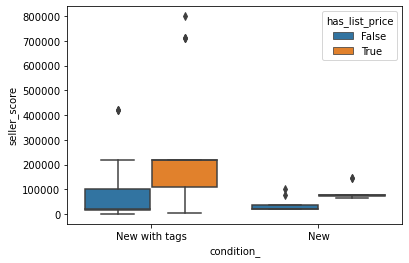

In [139]:
sns.boxplot(x = "condition_", y = "seller_score", hue= "has_list_price", data = deals_df)

In [140]:
# item price
deals_df['item_price'] = pd.to_numeric(deals_df['item_price'])
deals_df.groupby(['has_list_price', 'condition_']).agg({'item_price': ['mean', 'min', 'max']})

item_price                
                                     mean    min      max
has_list_price condition_                                
False          New            1566.000000  550.0   3999.0
               New with tags  2753.619048  599.0  13499.0
True           New            2410.363636  999.0   9499.0
               New with tags  2365.560000  599.0   7981.0

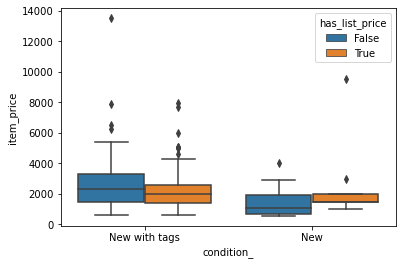

In [141]:
sns.boxplot(x = "condition_", y = "item_price", hue= "has_list_price", data = deals_df)

In [121]:
# list price
deals_df['list_price'] = pd.to_numeric(deals_df['list_price'])
deals_df.groupby(['has_list_price', 'condition_']).agg({'list_price': ['mean', 'min', 'max']})

list_price                 
                                     mean     min      max
has_list_price condition_                                 
False          New                    NaN     NaN      NaN
               New with tags          NaN     NaN      NaN
True           New            7539.545455  2339.0  40595.0
               New with tags  8007.226667  1698.0  24999.0

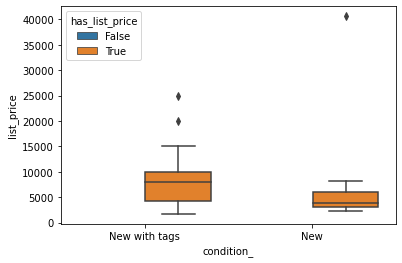

In [127]:
sns.boxplot(x = "condition_", y = "list_price", hue= "has_list_price", data = deals_df)

In [128]:
# items sold
deals_df['items_sold'] = pd.to_numeric(deals_df['items_sold'])
deals_df.groupby(['has_list_price', 'condition_']).agg({'items_sold': ['mean', 'min', 'max']})

items_sold                
                                     mean   min       max
has_list_price condition_                                
False          New            1979.125000  59.0    6278.0
               New with tags  1423.931818   1.0    6980.0
True           New            3774.000000  73.0   28143.0
               New with tags  7719.428571   1.0  181507.0

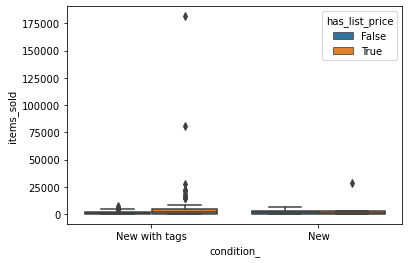

In [129]:
sns.boxplot(x = "condition_", y = "items_sold", hue= "has_list_price", data = deals_df)

In [130]:
# shipping price
deals_df['shipping_price'] = pd.to_numeric(deals_df['shipping_price'])
deals_df.groupby(['has_list_price', 'condition_']).agg({'shipping_price': ['mean', 'min', 'max']})

shipping_price        
                                       mean min max
has_list_price condition_                          
False          New                        0   0   0
               New with tags              0   0   0
True           New                        0   0   0
               New with tags              0   0   0